In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from fem2D import readGmsh4

In [2]:
# definition d'un objet element

class Node:
    id = 0
    def __init__(self, x, y, region):
        self.id = Node.id
        Node.id += 1
        self.x = x
        self.y = y
        self.region = region
        
    def __repr__(self):
        return f"Node {self.id} [{self.x},{self.y}], region = {self.region}"

class Element:
    id = 0
    def __init__(self, nodes):
        self.nodes = nodes
        self.id = Element.id
        Element.id += 1
        
    def getCoords(self):
        return np.array([[n.x,n.y] for n in self.nodes])
    
    def __repr__(self):
        return f"Element {self.id}\nNodes : {[n.id for n in self.nodes]}\nCoords : {self.getCoords()}"

def plotMesh(elements, nodes, regions = []):
    
    fig, ax = plt.subplots()
    
    regionsSymbols = ["+b", "+r", "+g", "+y"]
    
    for e in elements:
        coords = e.getCoords()
        plt.fill(coords[:,0], coords[:,1], color="greenyellow", alpha=0.5, ec="k")
        
    for (i,r) in enumerate(regions):
        for n in nodes:
            if n.region == r: plt.plot(n.x, n.y, regionsSymbols[i%4])
            
    ax.set_aspect("equal", "box")
    plt.show()

In [3]:
# definition du maillage

Node.id = 0
Element.id = 0

N = 10
L = 100.0
xCoords = np.linspace(0.0, L, N+1)
dof = (N+1)*(N+1)

# regions index
omega, bot, right, top, left = 1, 2, 3, 4, 5
Ttop, Tbot = 10.0, 30.0

nodesCoord = np.array([[[x,y] for x in xCoords] for y in xCoords]).reshape((dof,2))
nodes = [Node(coord[0], coord[1], 2 if coord[1] == 0.0 else 1) for coord in nodesCoord]

elements = []
for i in range(N*N):
    nodesIdx = [i+i//N,i+1+i//N,i+N+2+i//N,i+N+1+i//N]
    elements.append(Element([nodes[n] for n in nodesIdx]))

In [3]:
# chargement d'un maillage

Node.id = 0
Element.id = 0

file = "../meshes/t2.msh"
    
regions = [
        (1, 1),
        (1, 2)
        ]
    
elements, nodes = readGmsh4(file, regions) 
dof = len(nodes)

Element 0
Nodes : [1788, 86, 87, 1787]
Coords : [[6.49670762 0.10086606]
 [6.47096774 0.        ]
 [6.58064516 0.        ]
 [6.60546438 0.10097851]]

Node 1788 [6.496707622610066,0.1008660590497796], region = 0

Node 86 [6.47096774192582,0.0], region = 1



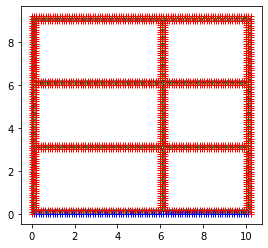

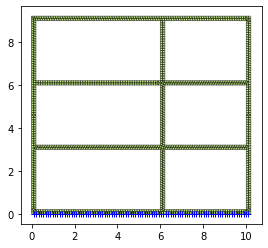

In [4]:
print(elements[0])
print(elements[0].nodes[0])
print(elements[0].nodes[1])
plotMesh(elements, nodes, [1,2]) #region 2 for down boundary
plotMesh(elements, nodes, [1,3]) #region 3 for all other boundaries

In [5]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 6

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

In [6]:
# interpolateur (P1 : linéaire)

Nelem = 4

# construction de la matrice nodale et détermination des coefficients
for e in elements:
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    nodal = np.zeros((4,3))
    for i in range(4):
        nodal[i,0] = 1
        nodal[i,1] = X[i]
        nodal[i,2] = Y[i]
    e.det = np.linalg.det(nodal[:-1])*2
    
    coefs = []
    for i in range(3):
        B = np.zeros(3)
        B[i] = 1
        coefs.append(np.linalg.solve(nodal[:-1], B))
    coefs.append(np.linalg.solve(nodal[1:], np.array([0,0,1])))
    e.coefs = coefs

In [7]:
# Détermination des coefficients de Lamé

# pour du béton en compression
Young = 11
Poisson = 0.15

lambda_coef = (Young*Poisson) / ((1+Poisson)*(1-2*Poisson))
mu_coef = Young / (2*(1+Poisson))

D = np.array([[lambda_coef + 2*mu_coef, lambda_coef, 0], [lambda_coef, lambda_coef + 2*mu_coef, 0], [0, 0, mu_coef]])
D

array([[11.61490683,  2.04968944,  0.        ],
       [ 2.04968944, 11.61490683,  0.        ],
       [ 0.        ,  0.        ,  4.7826087 ]])

In [8]:
# Détermination des matrices pour l'élasticité V2

for e in tqdm(elements):
    
    coefs = e.coefs
    BN1, BN2, BN3 = [], [], []
    for a in range(Nelem):
        BN1.extend([coefs[a][1], 0])
        BN2.extend([0, coefs[a][2]])
        BN3.extend([coefs[a][2], coefs[a][1]])
    e.BN = np.array([BN1, BN2, BN3], dtype=object)

100%|███████████████████████████████████████████████████████████████████████████| 1226/1226 [00:00<00:00, 72102.65it/s]


In [10]:
# Calcul des matrices élémentaires locales -> à optimiser

for e in tqdm(elements):

    e.Ke = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):

            fk = lambda u,v: sum(sum( e.BN[k,i](u,v) * D[k,h] * e.BN[h,j](u,v) *e.detJ(u,v) for k in range(3)) for h in range(3))
            e.Ke[i,j] = int2D(fk)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


In [20]:
# Calcul des matrices élémentaires locales -> à optimiser V2

for e in tqdm(elements):

    e.Ke = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):

            e.Ke[i,j] = sum(sum( e.BN[k,i] * D[k,h] * e.BN[h,j] * e.det for k in range(3)) for h in range(3))

100%|█████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:01<00:00, 904.17it/s]


In [22]:
np.linalg.det(elements[0].Ke)

0.0

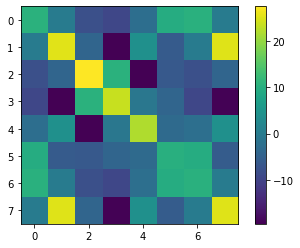

In [21]:
plt.imshow(elements[0].Ke)
plt.colorbar()

In [22]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((2*dof,2*dof))

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            
            K[2*n1.id,2*n2.id] += e.Ke[2*i,2*j]
            K[2*n1.id,2*n2.id+1] += e.Ke[2*i,2*j+1]
            K[2*n1.id+1,2*n2.id] += e.Ke[2*i+1,2*j]
            K[2*n1.id+1,2*n2.id+1] += e.Ke[2*i+1,2*j+1]

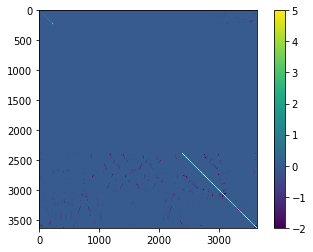

In [27]:
# Conditions aux limites

F = np.zeros(2*dof)
boundary = 2
boundary_list = []
shift = [0.2, 0.2]

for n in nodes:
    if n.region == boundary:
        K[2*n.id,:] = 0
        K[2*n.id+1,:] = 0
        K[2*n.id, 2*n.id] = 1
        K[2*n.id+1, 2*n.id+1] = 1
        F[2*n.id] = shift[0]
        F[2*n.id+1] = shift[1]

#%matplotlib notebook
plt.imshow(K, vmin = -2, vmax = 5)
plt.colorbar()
plt.show()

In [28]:
# Résolution du système

U = np.linalg.solve(K, F)

In [16]:
def plotNodesValues(U, nodes, ax):
    dots = ax.scatter([n.x + U[2*(n.id-1)] for n in nodes], [n.y + U[2*(n.id-1)+1] for n in nodes], c=np.sqrt(U[::2]**2 + U[1::2]**2), zorder=5)
    plt.colorbar(dots)
    ax.set_aspect("equal", "box")
    
def plotMeshLimits(elements, ax):
    for e in elements:
        coords = e.getCoords()
        ax.fill(coords[:,0], coords[:,1], facecolor="none", ec="k", zorder=1)

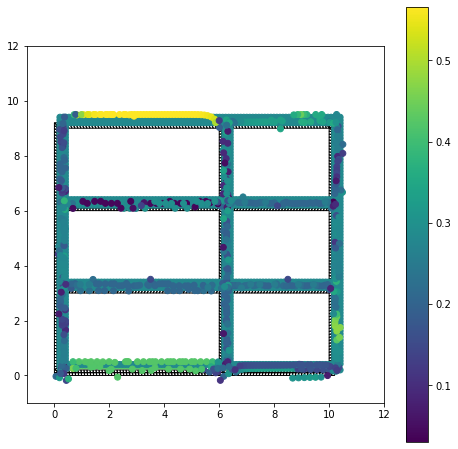

In [31]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylim(-1,12)
ax.set_xlim(-1,12)


plotNodesValues(U, nodes, ax)
plotMeshLimits(elements, ax)

In [29]:
def plotBourrin(U, elements, ax, mesh=False):
        
    u = np.linspace(-1, 1, 10)
    uu, vv = np.meshgrid(u,u)
    
    vmin, vmax = U.min(), U.max()
    
    for e in elements:
        
        coords = e.getCoords()
        X, Y = coords[:,0], coords[:,1]
        
        zitp = interp(phi, [U[n.id] for n in e.nodes])
        xitp = interp(phi, X)
        yitp = interp(phi, Y)
        
        Z = zitp(uu, vv)
        X = xitp(uu, vv)
        Y = yitp(uu, vv)
        
        dots = plt.scatter(X, Y, marker=",", c = Z, vmin=vmin, vmax=vmax)
    
    plt.colorbar(dots)
    
    if mesh:
        for e in elements:
            n1,n2,n3,n4 = e.nodes        
            plt.plot([n1.x,n2.x], [n1.y,n2.y], "k", lw=0.5)
            plt.plot([n2.x,n3.x], [n2.y,n3.y], "k", lw=0.5)
            plt.plot([n3.x,n4.x], [n3.y,n4.y], "k", lw=0.5)
            plt.plot([n4.x,n1.x], [n4.y,n1.y], "k", lw=0.5)
    
    ax.set_aspect("equal", "box")        

NameError: name 'interp' is not defined

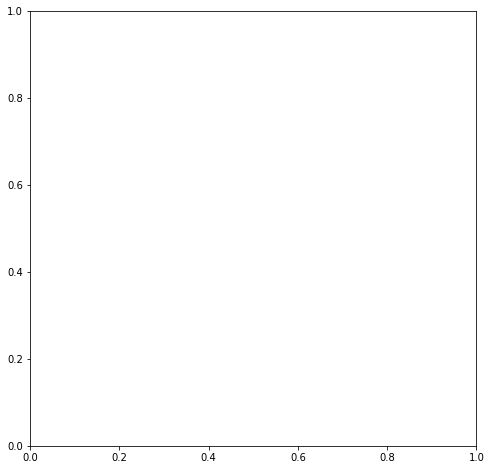

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

plotBourrin(U, elements, ax)
plotMeshLimits(elements, ax)

ValueError: z array must have same length as triangulation x and y arrays

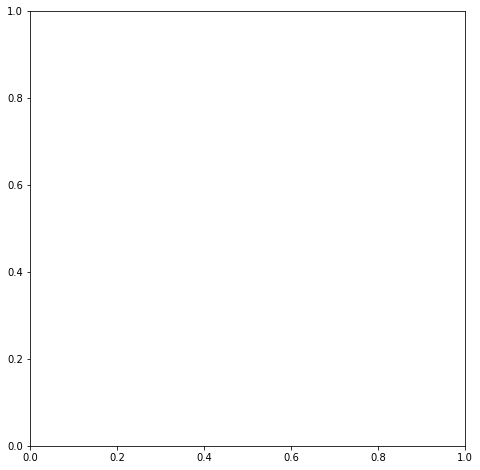

In [31]:
def quad2tri(e):
    n0, n1, n2, n3 = e.nodes
    return Element([n0, n1, n2]), Element([n2, n3, n0])

def plotFemResults(nodes, elements, U, ax):
    
    ax.set_aspect("equal", "box")        
    
    X = np.array([n.x for n in nodes])
    Y = np.array([n.y for n in nodes])
    elmtNodes = np.array([[n.id for n in e.nodes] for e in elements])
    levels = np.linspace(U.min(), U.max(), 100)
    
    im = ax.tricontourf(X, Y, elmtNodes, U, levels=levels) 
    plt.colorbar(im)

elementsTri = []
for e in elements:
    e1, e2 = quad2tri(e)
    elementsTri.append(e1)
    elementsTri.append(e2)


fig,ax = plt.subplots(figsize=(8,8))

plotFemResults(nodes, elementsTri, U, ax) 
plotMeshLimits(elements, ax)   